# DTWで異常スコアの監視

横ずれと上下シフトが検出できない

In [5]:
# ============================================================
# DWT特徴量 + PCA(MSPC: T²/Q) 解析（testのみをラベル可視化）
# - meta_dwt_train.csv / meta_dwt_test.csv から win_label を読み込む
# - score(T²/Q) は test だけ描画し、ラベルごとに背景色を塗る
# - scatter / pairplot は test だけ描画し、ラベルごとに色分け
# ============================================================

%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ----------------------------
# 設定（ここだけ変えればOK）
# ----------------------------
TRAIN_FEAT_CSV = "features_dwt_train.csv"
TEST_FEAT_CSV  = "features_dwt_test.csv"
TRAIN_META_CSV = "meta_dwt_train.csv"
TEST_META_CSV  = "meta_dwt_test.csv"

LABEL_COL = "win_label"   # meta内のラベル列名
VAR_RATIO = 0.95          # PCAの累積寄与率（固定次元にしたい場合はN_COMPを指定）
N_COMP    = None          # 例: 8（NoneならVAR_RATIOで決める）

ALPHA = 0.995             # 閾値：trainスコアの分位点
PAIRPLOT_K = 4            # pairplotに使うPC数（重いなら2〜3）

# ラベル名・背景色（必要なら自由に変更）
label_name = {
    0: "正常",
    1: "異常1",
    2: "異常2",
    3: "異常3",
    4: "異常4",
}
label_color = {
    0: "C0",
    1: "C1",
    2: "C2",
    3: "C3",
    4: "C4",
}

# ============================================================
# 0) 入力（特徴量とmeta）
# ============================================================
df_tr = pd.read_csv(TRAIN_FEAT_CSV)
df_te = pd.read_csv(TEST_FEAT_CSV)

meta_tr = pd.read_csv(TRAIN_META_CSV)
meta_te = pd.read_csv(TEST_META_CSV)

if LABEL_COL not in meta_te.columns:
    raise ValueError(f"meta_te に {LABEL_COL} がありません。columns={list(meta_te.columns)}")

# 念のため列整合（trainの列に合わせる）
common_cols = [c for c in df_tr.columns if c in df_te.columns]
df_tr = df_tr[common_cols].copy()
df_te = df_te[common_cols].copy()

# 数値化 + 欠損埋め（train平均）
Xtr = df_tr.apply(pd.to_numeric, errors="coerce").to_numpy(float)
Xte = df_te.apply(pd.to_numeric, errors="coerce").to_numpy(float)

col_mean = np.nanmean(Xtr, axis=0)
for X in (Xtr, Xte):
    bad = ~np.isfinite(X)
    if bad.any():
        X[bad] = col_mean[np.where(bad)[1]]

y_te = meta_te[LABEL_COL].to_numpy()


In [6]:

# ============================================================
# 1) 標準化 → PCA（trainで学習）
# ============================================================
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

pca_full = PCA(svd_solver="full").fit(Xtr_s)
cum = np.cumsum(pca_full.explained_variance_ratio_)
a = int(N_COMP) if N_COMP is not None else int(np.searchsorted(cum, VAR_RATIO) + 1)

pca = PCA(n_components=a, svd_solver="full")
Ttr = pca.fit_transform(Xtr_s)     # (Ntr, a)
Tte = pca.transform(Xte_s)         # (Nte, a)

P = pca.components_.T              # (p, a)
lam = pca.explained_variance_      # (a,)

Xtr_hat = Ttr @ P.T
Xte_hat = Tte @ P.T
Etr = Xtr_s - Xtr_hat
Ete = Xte_s - Xte_hat

# ============================================================
# 2) SPCスコア（T² と Q） + 閾値（train分位点）
# ============================================================
T2_tr = np.sum((Ttr ** 2) / lam, axis=1)
T2_te = np.sum((Tte ** 2) / lam, axis=1)
Q_tr  = np.sum(Etr ** 2, axis=1)
Q_te  = np.sum(Ete ** 2, axis=1)

T2_thr = float(np.quantile(T2_tr, ALPHA))
Q_thr  = float(np.quantile(Q_tr,  ALPHA))



=== 寄与: test idx=1059, label=4 (異常4) ===

T² 寄与 上位20:
variable
s1__KURT_L1      7160.444251
s1__MAXABS_L1    2703.719437
s1__KURT_L3       258.014340
s1__MAXABS_L3     162.021827
s1__E_L3          101.940313
s1__H_abs_L1       96.589064
s1__E_L1           86.906580
s1__STD_L1         76.609197
s1__RMS_L1         66.458909
s1__RMS_L3         59.587269
s1__H_abs_L3       53.790717
s1__STD_L3         40.341007
s1__KURT_L2        28.162493
s1__MAXABS_L2      19.884179
s1__KURT_L4        18.046808
s1__H_abs_L4       17.090034
s2__MAXABS_L3      12.040642
s1__E_L2           11.558173
s1__MAXABS_L4      11.243741
s1__RMS_L2          8.307972

Q 寄与 上位20:
variable
s1__KURT_L1      2995.972058
s1__MAXABS_L1    1660.194604
s1__H_abs_L1      813.221596
s1__E_L1          110.357049
s1__H_abs_L3       85.196891
s2__MAXABS_L3      77.966587
s2__H_abs_L3       44.221373
s1__KURT_L2        43.390890
s1__STD_L1         38.572787
s1__MAXABS_L3      31.745689
s1__KURT_L3        30.295140
s1__H_abs_L2    

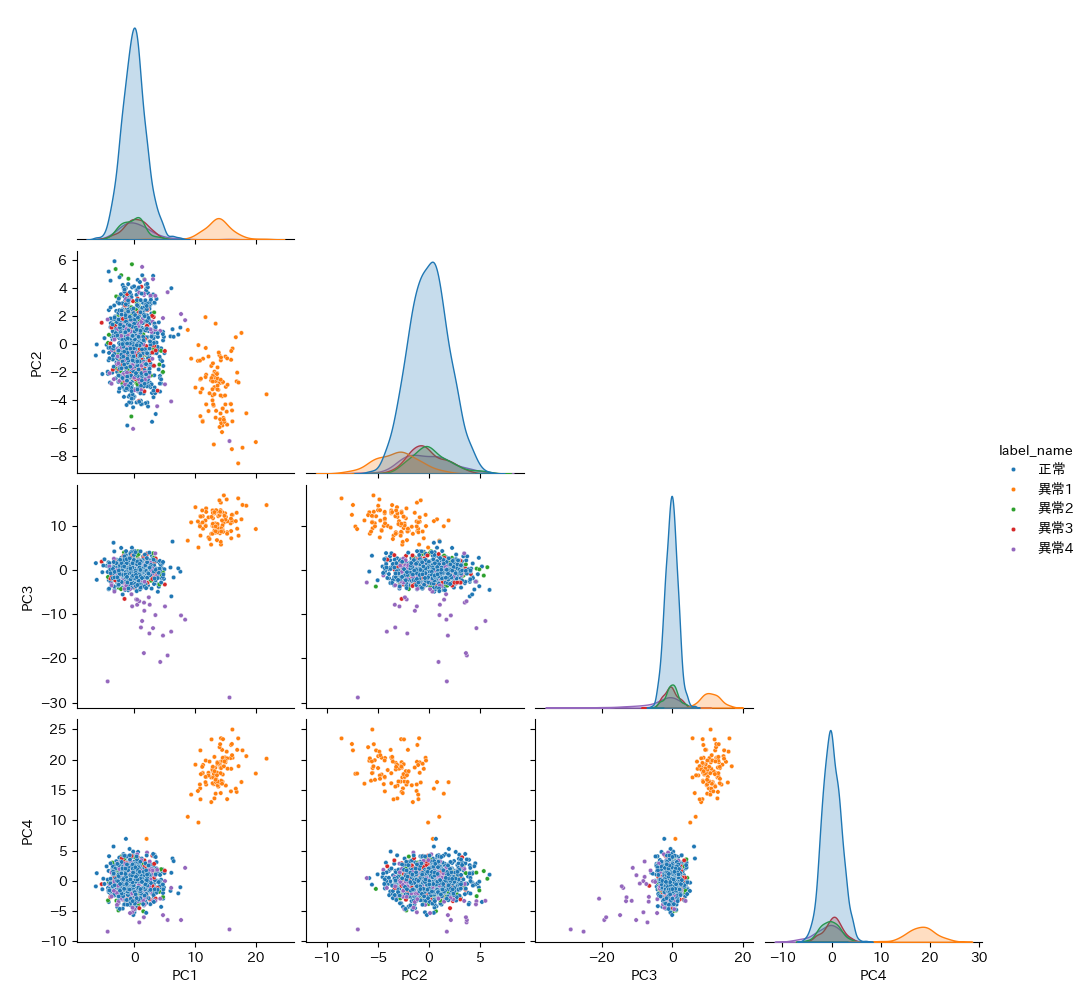

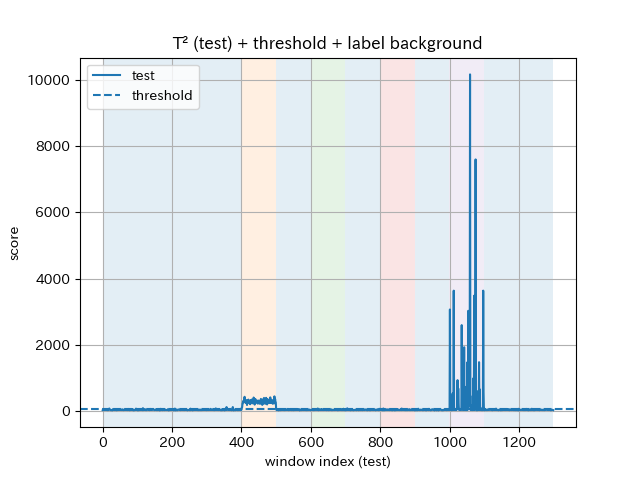

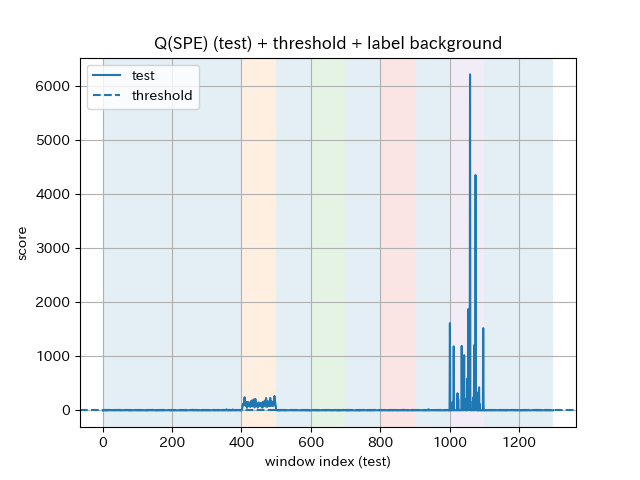

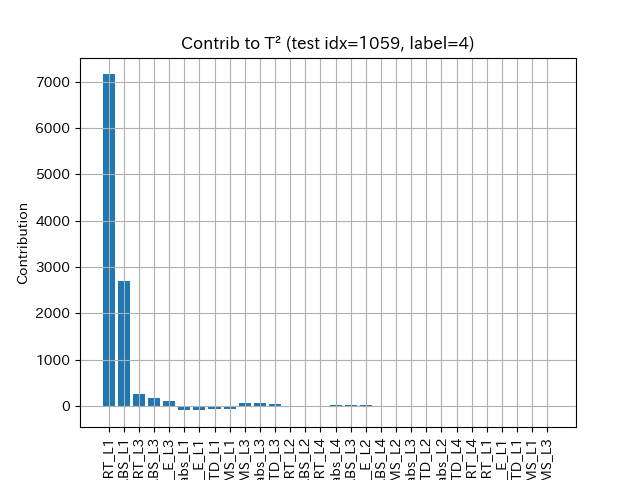

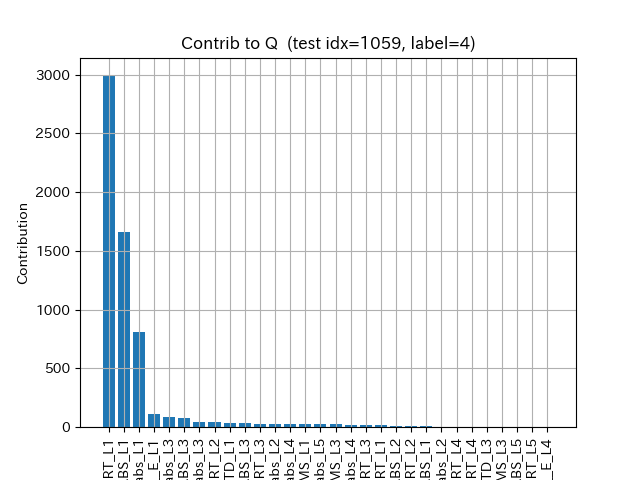

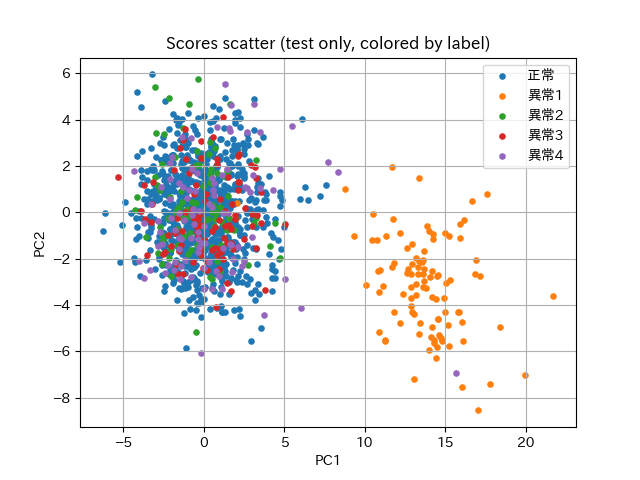

In [7]:

# ============================================================
# 3) ラベル→色の準備（未知ラベルがあっても破綻しない）
# ============================================================
uniq = pd.unique(pd.Series(y_te).dropna()).tolist()
uniq = sorted([int(u) for u in uniq if np.isfinite(u)])

# label_colorに無いラベルは自動で色を割り当て
cmap = plt.get_cmap("tab10")
for i, lab in enumerate(uniq):
    if lab not in label_color:
        label_color[lab] = cmap(i % 10)
    if lab not in label_name:
        label_name[lab] = f"label{lab}"


# ============================================================
# 4) 背景塗り（ラベル区間をまとめて塗る）
# ============================================================
def shade_by_label(ax, labels, color_map, alpha=0.12):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0:
        return
    s = 0
    while s < n:
        lab = labels[s]
        e = s + 1
        while e < n and labels[e] == lab:
            e += 1
        if np.isfinite(lab):
            lab_i = int(lab)
            ax.axvspan(s - 0.5, e - 0.5, color=color_map.get(lab_i, "0.8"), alpha=alpha, lw=0)
        s = e

# ============================================================
# 5) スコアと閾値（testのみ）＋ 背景をラベルで色分け
# ============================================================
def plot_score_test_with_threshold_and_label_bg(score_te, thr, y_te, title):
    fig, ax = plt.subplots()
    ax.plot(score_te, label="test")
    ax.axhline(thr, linestyle="--", label="threshold")
    shade_by_label(ax, y_te, label_color, alpha=0.12)
    ax.set_xlabel("window index (test)")
    ax.set_ylabel("score")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    return fig, ax

plot_score_test_with_threshold_and_label_bg(T2_te, T2_thr, y_te, "T² (test) + threshold + label background")
plot_score_test_with_threshold_and_label_bg(Q_te,  Q_thr,  y_te, "Q(SPE) (test) + threshold + label background")

# ============================================================
# 6) 寄与（Contribution）: 最大スコアのtest窓を対象（ラベルも表示）
# ============================================================
def contributions_T2_Q(x_s, e_s, P, lam):
    invLam = np.diag(1.0 / lam)
    g = P @ invLam @ P.T @ x_s
    cont_T2 = x_s * g
    cont_Q  = e_s ** 2
    return cont_T2, cont_Q

i_star = int(np.argmax(T2_te + Q_te))
lab_star = int(y_te[i_star]) if np.isfinite(y_te[i_star]) else None
print(f"\n=== 寄与: test idx={i_star}, label={lab_star} ({label_name.get(lab_star, lab_star)}) ===")

x_star = Xte_s[i_star]
e_star = Ete[i_star]
cont_T2, cont_Q = contributions_T2_Q(x_star, e_star, P, lam)

df_cont = pd.DataFrame({"variable": df_tr.columns, "cont_T2": cont_T2, "cont_Q": cont_Q}).set_index("variable")

print("\nT² 寄与 上位20:")
print(df_cont["cont_T2"].abs().sort_values(ascending=False).head(20).to_string())
print("\nQ 寄与 上位20:")
print(df_cont["cont_Q"].sort_values(ascending=False).head(20).to_string())

def plot_top_contrib(series, title, top=30):
    s = series.copy()
    s = s.reindex(s.abs().sort_values(ascending=False).head(top).index)
    fig, ax = plt.subplots()
    ax.bar(range(len(s)), s.values)
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(s.index, rotation=90)
    ax.set_xlabel("Variable")
    ax.set_ylabel("Contribution")
    ax.set_title(title)
    ax.grid(True)
    return fig, ax

plot_top_contrib(df_cont["cont_T2"], f"Contrib to T² (test idx={i_star}, label={lab_star})", top=30)
plot_top_contrib(df_cont["cont_Q"],  f"Contrib to Q  (test idx={i_star}, label={lab_star})", top=30)

# ============================================================
# 7) PCAスコア散布図（testのみ、ラベル色分け） + pairplot（testのみ）
# ============================================================
k = min(a, PAIRPLOT_K)
df_scores_te = pd.DataFrame(Tte[:, :k], columns=[f"PC{i}" for i in range(1, k+1)])
df_scores_te["label"] = y_te
df_scores_te["label_name"] = pd.Series(y_te).apply(lambda v: label_name.get(int(v), str(v)) if np.isfinite(v) else "nan").to_numpy()

# PC1 vs PC2（testのみ）
if a >= 2:
    fig, ax = plt.subplots()
    for lab in uniq:
        m = (y_te == lab)
        ax.scatter(df_scores_te.loc[m, "PC1"], df_scores_te.loc[m, "PC2"], s=14, label=label_name[lab], c=label_color[lab])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Scores scatter (test only, colored by label)")
    ax.grid(True)
    ax.legend()

# pairplot（testのみ、ラベル色分け）
# 重い場合：PAIRPLOT_Kを2〜3にする、または df_scores_te.sample(n=2000, random_state=0) を使う
sns.pairplot(
    df_scores_te[[f"PC{i}" for i in range(1, k+1)] + ["label_name"]],
    hue="label_name",
    corner=True,
    plot_kws={"s": 10}
)
plt.show()
